In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir =r"C:\Users\ghwns\HJ_git\food-image-classification\data\raw" 

#Size 정하기
img_size = (224, 224) 
batch_size = 32

# 이미지를 하나씩 불러오면서 전처리 + 증강 해주는 도구이다.
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# 훈련 데이터
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# 검증 데이터
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 288 images belonging to 36 classes.
Found 71 images belonging to 36 classes.


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 사전 학습된 ResNet50 불러오기 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

# 커스텀 출력층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)        
x = Dense(128, activation='relu')(x)   
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,854,628 (91.00 MB)

 Trainable params: 266,916 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
#모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10
)

C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0198 - loss: 3.7956

C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.0213 - loss: 3.7950 - val_accuracy: 0.0423 - val_loss: 3.7404
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.0360 - loss: 3.6800 - val_accuracy: 0.0282 - val_loss: 3.6902
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.0239 - loss: 3.6338 - val_accuracy: 0.0282 - val_loss: 3.6510
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.0313 - loss: 3.6081 - val_accuracy: 0.0282 - val_loss: 3.6246
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.0238 - loss: 3.6312 - val_accuracy: 0.0141 - val_loss: 3.6075
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.0288 - loss: 3.5972 - val_accuracy: 0.0282 - val_loss: 3.5911
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.0375 - loss: 3.5884 - val_accuracy: 0.0563 - val_loss: 3.5947
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.0280 - loss: 3.5896 - val_accuracy: 0.0845 - val_loss: 3.5841
Epoch 9/10
9/9 ━━━━

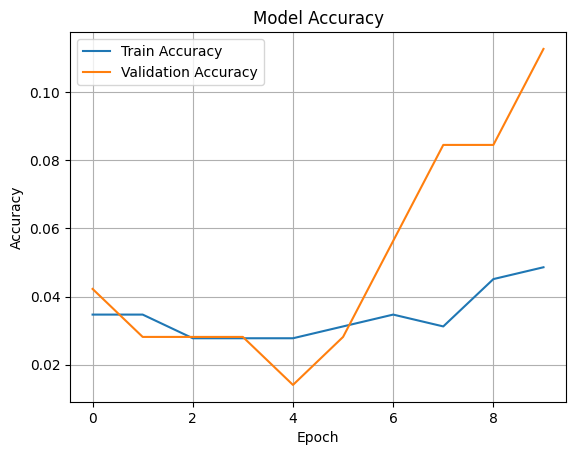

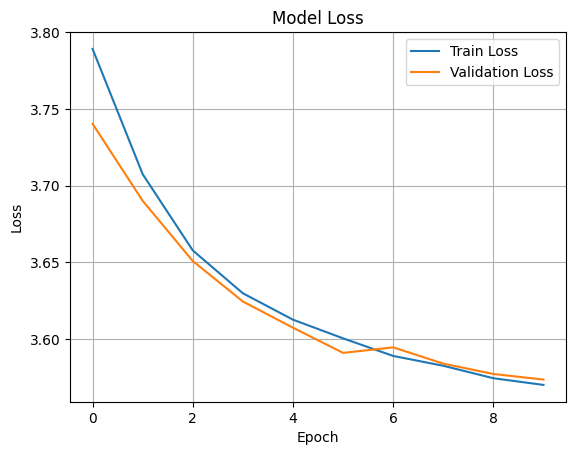

In [10]:
import matplotlib.pyplot as plt

# Accuracy 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
               precision    recall  f1-score   support

        apple       0.00      0.00      0.00         2
       banana       0.00      0.00      0.00         1
     beetroot       0.00      0.00      0.00         2
  bell pepper       0.00      0.00      0.00         2
      cabbage       0.00      0.00      0.00         2
     capsicum       0.00      0.00      0.00         2
       carrot       0.00      0.00      0.00         2
  cauliflower       0.00      0.00      0.00         2
chilli pepper       0.00      0.00      0.00         2
         corn       0.00      0.00      0.00         2
     cucumber       0.00      0.00      0.00         2
     eggplant       0.00      0.00      0.00         2
       garlic       0.00      0.00      0.00         2
       ginger       0.00      0.00      0.00         2
       grapes       0.00      0.00      0.00         2
     jalepeno       0.00      0.00      0.00         2
         kiwi       0.00   

C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


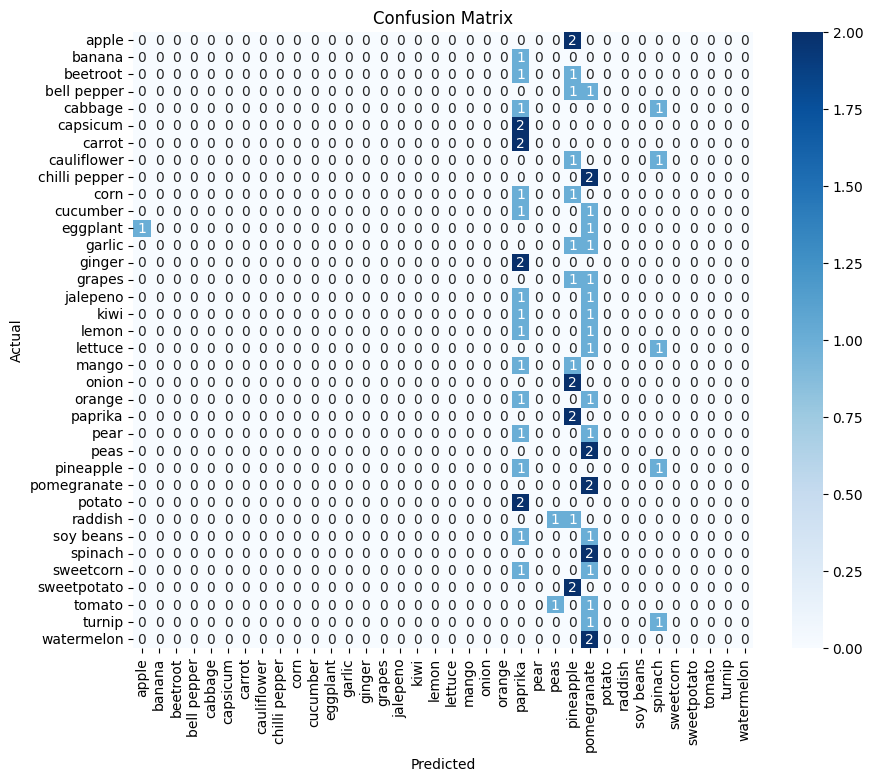

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_generator.shuffle = False
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


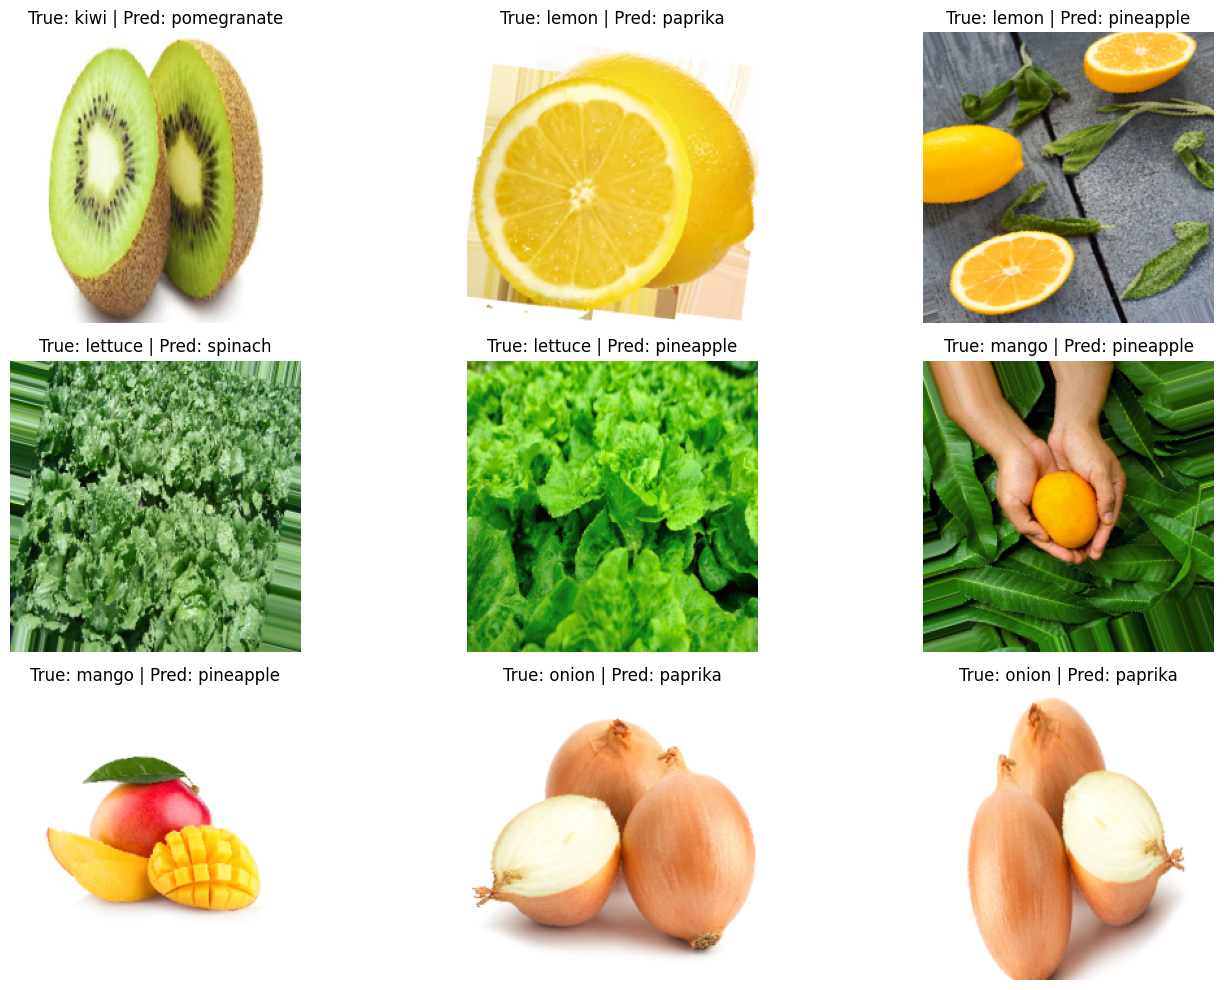

In [17]:
class_names = list(val_generator.class_indices.keys())


x_batch, y_batch = next(val_generator)
preds = model.predict(x_batch)

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    true_label = class_names[np.argmax(y_batch[i])]
    pred_label = class_names[np.argmax(preds[i])]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [18]:
model.save('models/food_classifier_resnet50.h5')